# Basic image stacking

Since slight imperfections in the tracking of the telescope mean that the same point in the sky does not necessarily fall on the same pixel, we sometimes have to reorient our images before we add them up ("stack" them). In this tutorial, we will see how that's done.

**Note:** In all our analysis, we will assume that we are using an equatorial mount, with a very small error in the polar alignment. Consequently, we only need to translate our image (no need for rotation) and even this by a relatively small number of pixels. If this is not the case, you are better off using more advanced stacking software like Siril. However, it is still -- in principle -- possible to do it with our package, just not very simple.

In [1]:
# The following lines are required so that the local ``astrolab`` package can be recognised by Python. 
# This is only necessary if you haven't installed the ``astrolab`` package on your machine.

import os
import sys
sys.path.insert(0, os.path.abspath("../../.."))

In [2]:
# Loading the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from astrolab import imaging as im

## Loading the light frames

If you have gone through the [Basic Image Reduction](image-reduction-tutorial.ipynb) tutorial notebook, you should know that to properly analyse any image, it first needs to be "reduced" using calibration frames (darks, biases, and flats). In this tutorial, we will ignore this calibration, and leave it as an exercise. We will instead focus on stacking multiple light frames together. Ideally, however, every light frame should first be reduced, and only then should the procedure detailed here be applied.

In [3]:
lightfiles = im.get_files("./data/imaging/ring/lights/*.fit", print_log=True)

Files loaded:
 ['./data/imaging/ring/lights/ring-0001L.fit'
 './data/imaging/ring/lights/ring-0002L.fit'
 './data/imaging/ring/lights/ring-0003L.fit'
 './data/imaging/ring/lights/ring-0004L.fit'
 './data/imaging/ring/lights/ring-0005L.fit']


## Naively stacking our lights

Let us begin by seeing what would happen if we were to naively stack the images by simply adding the pixel values one on top of the other. We can do this using the ``stack_files`` function of the ``astrolab.imaging`` module, and sending in the list of files ``lightfiles`` that we have loaded in the previous cell.

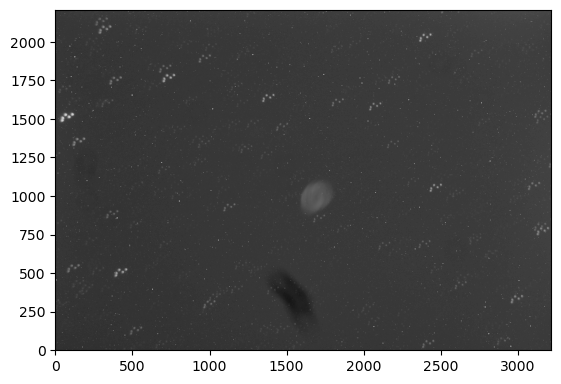

In [4]:
# Trying to naively stack the lights

naive_stack = im.stack_files(lightfiles)
im.display(naive_stack)
plt.show()

## Stacking images using single-star alignment

Clearly, the above method does not work. The stars have shifted slightly in the time between taking the images, which leads to the "trails" that you see in the above image.

The solution is as follows: we will try to find a "feature" (say, a bright star) in all the images by looking in some region of space sufficiently large. Once we have found this feature, we find its location in each of the images. We then shift the images until this feature aligns in all the images, and finally stack them. If everything has been done correctly, we should have a well stacked image!

We break this down into three steps: (i) finding the pixel location of a bright star in each image, (ii) using a template image, finding how much each image needs to be shifted to make the bright star overlap, and (iii) using these shifts to shift and stack the images.

### Step 1: Find the location of a bright star in each image

We can do this by using the ``find_star`` function of the ``astrolab.imaging`` module. This function accepts a search "region", within which the brightest pixel is returned. You can adjust this value to get the best results.

Frame  0 : Star located at pixel [397 483]
Frame  1 : Star located at pixel [399 499]
Frame  2 : Star located at pixel [418 519]
Frame  3 : Star located at pixel [441 506]
Frame  4 : Star located at pixel [462 522]


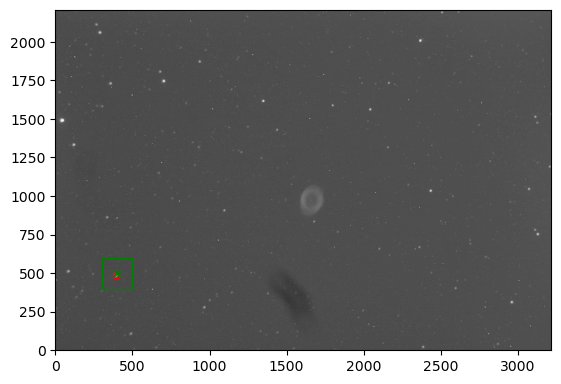

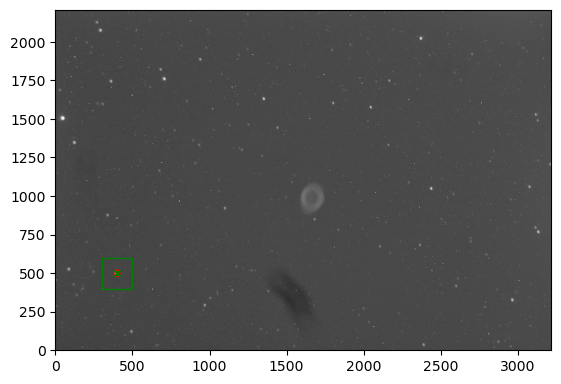

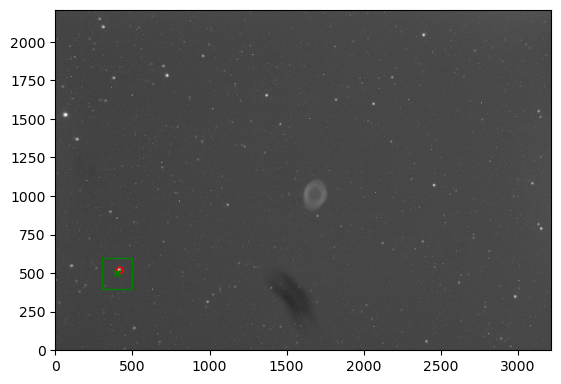

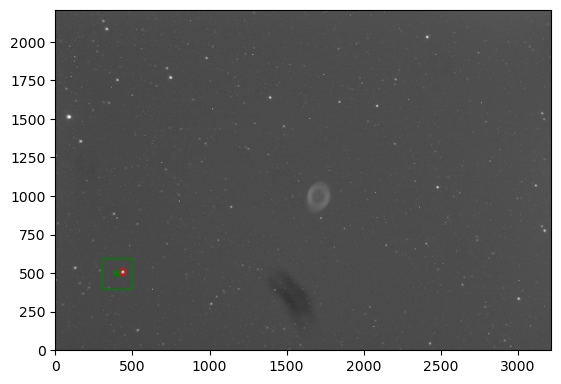

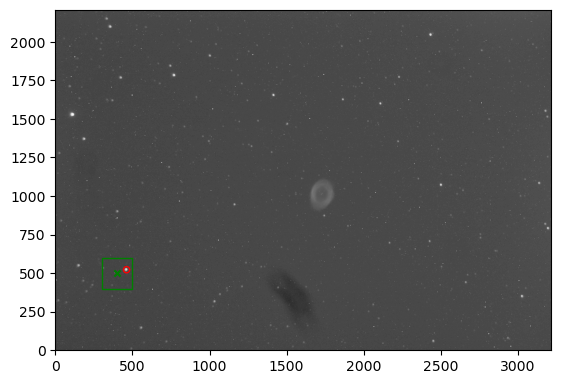

In [5]:
# Finding the location of a particular star in all five of the images.

for i in range(len(lightfiles)): # For every light image, find a specfic star in a rough region of space.
    this_image = im.load_image(lightfiles[i])
    this_star = im.find_star(this_image, star_pos=[400, 500], search=200, print_log=True)
    print("Frame ",i,": Star located at pixel", this_star)

### Step 2: Find how much each image needs to be shifted

For simplicity, let's use the first image as the template image. We find the location of the star in all other images, and see how much the images need to be "shifted" so that the locations match. This shift is just the "difference" between the location of the "template star" and the star in each image.

In [6]:
# Now that we have found the location of the star in each image, we do the following:
# Using one of the images as a "template" (say, the first one), find out what the displacement
# of the other images are from this image. We do this by seeing how far our detected star has moved between images.

template_image = im.load_image(lightfiles[0])
template_star = im.find_star(template_image, star_pos=[400, 500], search=200, print_log=False) 

shifts = np.zeros((len(lightfiles), 2)) # An array to store the coordinates by which to shift each star to align with the first ("template") image

array_of_images = np.zeros((len(lightfiles), len(template_image), len(template_image[0]))) # Array of images, to be sent into the ``stack`` function

for i in range(len(lightfiles)): # For every light image, find a specfic star
    this_image = im.load_image(lightfiles[i])
    this_star = im.find_star(this_image, star_pos=[400, 500], search=200, print_log=False)
    
    array_of_images[i] = this_image
    shifts[i] = this_star - template_star

print(shifts)

[[ 0.  0.]
 [ 2. 16.]
 [21. 36.]
 [44. 23.]
 [65. 39.]]


In the above shifts, you can see that the first image has to shift by a vector "``[0,0]``", as is
to be expected, since it was the template image. The other images have to move by the amounts
specified so that all the images "align".

### Step 3: Shift and stack the images

We can now use these ``shifts`` to stack the images using the ``imaging.stack`` function. This function accepts an array of coordinate "shifts", as well as an array of images. It will then take the array of images, shift each image by the corresponding shift, and average them.

In [7]:
# Stacking the array of images, with the provided shifts

stacked_image = im.stack(array_of_images, shifts=shifts, print_log=True)

Shifted image 1 by vector [0. 0.] .
Shifted image 2 by vector [ 2. 16.] .
Shifted image 3 by vector [21. 36.] .
Shifted image 4 by vector [44. 23.] .
Shifted image 5 by vector [65. 39.] .


## Cropping and analysing the final image

We can now display this stacked image. You will notice two things: first, the top and right edges
of the image are mostly black. This is a result of the arrays being "shifted" before averaging, causing some regions to be "empty". Consequently, there will be parts of the image array that are very close to zero (due to shifting the images),
and these parts will mess with the normalisation of our display (because we're using a log scale to stetch our image by
default. We could, of course, use a linear scale, but many features would not be visible. Another possibility is to
use the ``norm_array`` parameter in the ``imaging.display`` function. This parameter uses a _different_ array to
do the log-stretching. In our case, we have used the template_image, which has no such values close to zero, and therefore
gives a more faithful stretching.

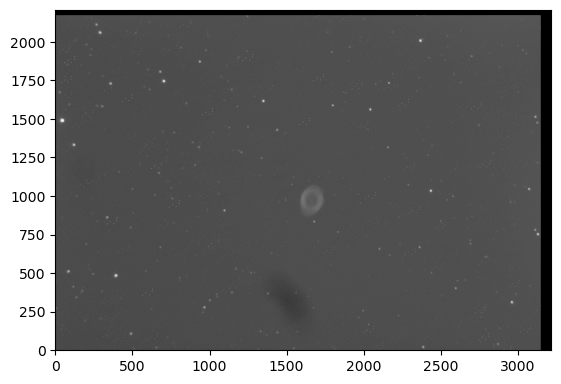

In [8]:
im.display(stacked_image, norm_array=template_image)

Let's now crop this array using the ``imaging.crop`` function so that the edges are removed.

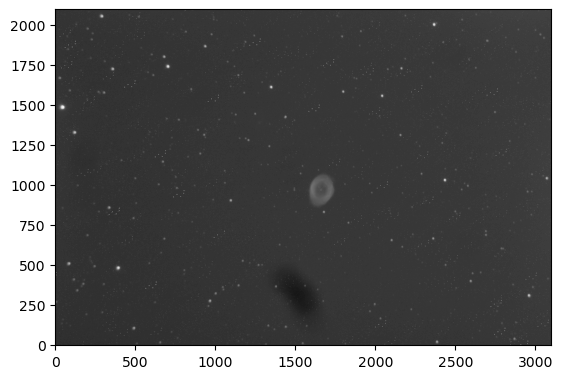

In [9]:
# Cropping the stacked image, so that the edges don't appear

cropped_stack = im.crop(stacked_image, left=None, right=3100, top=2100, bottom=0, print_log=True)

Now, we can compare our properly stacked image with the "naively" stacked image.

**Note:** To properly compare them, we also crop the naively stacked image to the same dimensions.

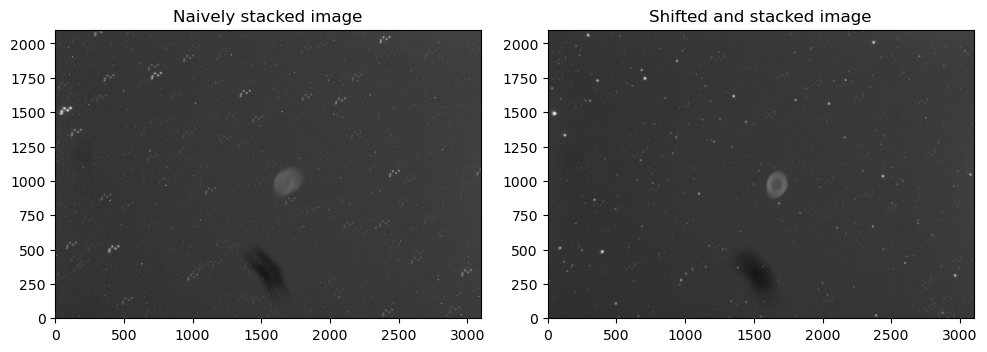

In [10]:
# Cropping and comparing the "naively stacked" and "shifted and stacked images".

cropped_naive_stack = im.crop(naive_stack, left=None, right=3100, top=2100, bottom=0) # Crop the naively stacked image by the same amount 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].set_title("Naively stacked image")
im.display(cropped_naive_stack, fig=fig, ax=axes[0])

axes[1].set_title("Shifted and stacked image")
im.display(cropped_stack, fig=fig, ax=axes[1])
plt.tight_layout()